In [1]:
import sys
import json
sys.path.append("/global/homes/s/seanjx/gigalens/src")

import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp

from astropy.io import fits
from astropy.visualization import simple_norm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Plots.model_plot as model_plot
from lenstronomy.Util import util

from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import myfunctions

In [2]:
#load observation data, do masking
f=fits.open('psf246.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout246.npy")

f=fits.open('final_96_drz.fits')
background_rms=0.00788315
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

In [3]:
path = "output/"+"246_2024-07-26 17:26:43.180945"
prior, phys_model, phys_model_Forward, SingleSources = myfunctions.readJson(path+"/prior.json")[0:4]
err_map = np.load(path+"/err_map.npy")

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
try: 
    inputFile = open(path+"/bestHMC.json")
    best_HMC = json.load(inputFile)
    print("HMC loaded")
    MAPorHMC = "HMC"
except: 
    prob_model = BackwardProbModel(prior, observed_img, err_map, background_rms=background_rms, exp_time=exp_time)
    best = np.load(path+"/best.npy")
    best_HMC = prob_model.bij.forward(best.tolist()[0])
    MAPorHMC = "MAP"
    print("MAP loaded")

HMC loaded


In [4]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

47 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [5]:
for ii, thing in enumerate(best_HMC):
    for iii, thing2 in enumerate(thing):
        for iv in thing2:
            best_HMC[ii][iii][iv] = float(best_HMC[ii][iii][iv])

In [6]:
plt.style.use('default')
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)

kwargs_data = sim_util.data_configure_simple(numPix*2, deltaPix)
data = ImageData(**kwargs_data)
_coords = data
lensModel = LensModel(lens_model_list=priorObjects[0])
kwargs_lens = best_HMC[0]
print(kwargs_lens)
extent = (-numPix/2*deltaPix, numPix/2*deltaPix, -numPix/2*deltaPix, numPix/2*deltaPix)
scale_length = 1 #arcsec

def convertEllipticity(e1, e2):
    phi = jnp.arctan2(e2, e1) / 2
    c = jnp.minimum(jnp.sqrt(e1 ** 2 + e2 ** 2), 0.9999)
    q = (1 - c) / (1 + c)
    return float(q), float(phi)

print(best_HMC[0][0]['e1'],best_HMC[0][0]['e2'])
print(convertEllipticity(best_HMC[0][0]['e1'],best_HMC[0][0]['e2']))

[{'theta_E': 2.7446494102478027, 'gamma': 2.2237184047698975, 'e2': 0.1435532420873642, 'e1': 0.023939818143844604, 'center_y': -0.09305573254823685, 'center_x': 0.08305220305919647}, {'gamma2': 0.04194113612174988, 'gamma1': -0.04735952615737915}]
0.023939818143844604 0.1435532420873642
(0.7459080219268799, 0.7027754783630371)


In [7]:
mass = best_HMC[0]
lens_light = best_HMC[1]
source_light = best_HMC[2]
for ii, thing in enumerate(lens_light):
    thing["Ie"] = float(coeffs[0][ii]*1/deltaPix**2)

counter = ii+1
for ii, thing in enumerate(source_light):
    if priorObjects[2][ii] == "SHAPELETS":
        n_max = phys_model.getProfiles()[2][ii].n_max
        #n_max = 5
        n_layers = int((n_max + 1) * (n_max + 2) / 2)
        decimal_places = len(str(n_layers))
        amps = []
        for iii in range(n_layers):
            amps.append(f"amp{str(iii).zfill(decimal_places)}")
            thing[amps[iii]]=np.array([coeffs[0][counter]*1/deltaPix**2])
            counter = counter + 1
    else:
        thing["Ie"] = float(coeffs[0][counter]*1/deltaPix**2)
        counter = counter + 1

lens_sim_deconstructed = LensSimulator(phys_model_Forward, sim_config, bs=1)

sourcesimulated = lens_sim_deconstructed.simulate([[], [], source_light])
masssimulated = lens_sim_deconstructed.simulate([mass, [], source_light])
lenssimulated = lens_sim_deconstructed.simulate([[], lens_light, []])

individualSourceSimulations = []
for ii, source in enumerate(source_light):
    OneSourceModel = LensSimulator(SingleSources[ii], sim_config, bs=1)
    individualSourceSimulations.append(OneSourceModel.simulate([mass, [], [source]]))    


In [8]:
print(best_HMC)
print(phys_model.getProfiles()[2][0].n_max,)#phys_model.getProfiles()[2][1].n_max)

[[{'theta_E': 2.7446494102478027, 'gamma': 2.2237184047698975, 'e2': 0.1435532420873642, 'e1': 0.023939818143844604, 'center_y': -0.09305573254823685, 'center_x': 0.08305220305919647}, {'gamma2': 0.04194113612174988, 'gamma1': -0.04735952615737915}], [{'n_sersic': 2.220963478088379, 'e2': -0.10710277408361435, 'e1': 0.19163301587104797, 'center_y': -0.04623666778206825, 'center_x': 0.036211006343364716, 'R_sersic': 0.34778374433517456, 'Ie': 68.79147338867188}, {'n_sersic': 5.600860595703125, 'e2': 0.0086669921875, 'e1': 0.17012086510658264, 'center_y': -0.04991474002599716, 'center_x': -0.12112635374069214, 'R_sersic': 3.246692180633545, 'Ie': 5.021224021911621}, {'n_sersic': 1.7558940649032593, 'e2': 0.27864646911621094, 'e1': -0.26709264516830444, 'center_y': 0.07803438603878021, 'center_x': 3.0990185737609863, 'R_sersic': 0.1589994728565216, 'Ie': 45.05239486694336}, {'n_sersic': 3.9390835762023926, 'e2': -0.11374405026435852, 'e1': 0.06151144206523895, 'center_y': -2.9225249290466

1.2317793


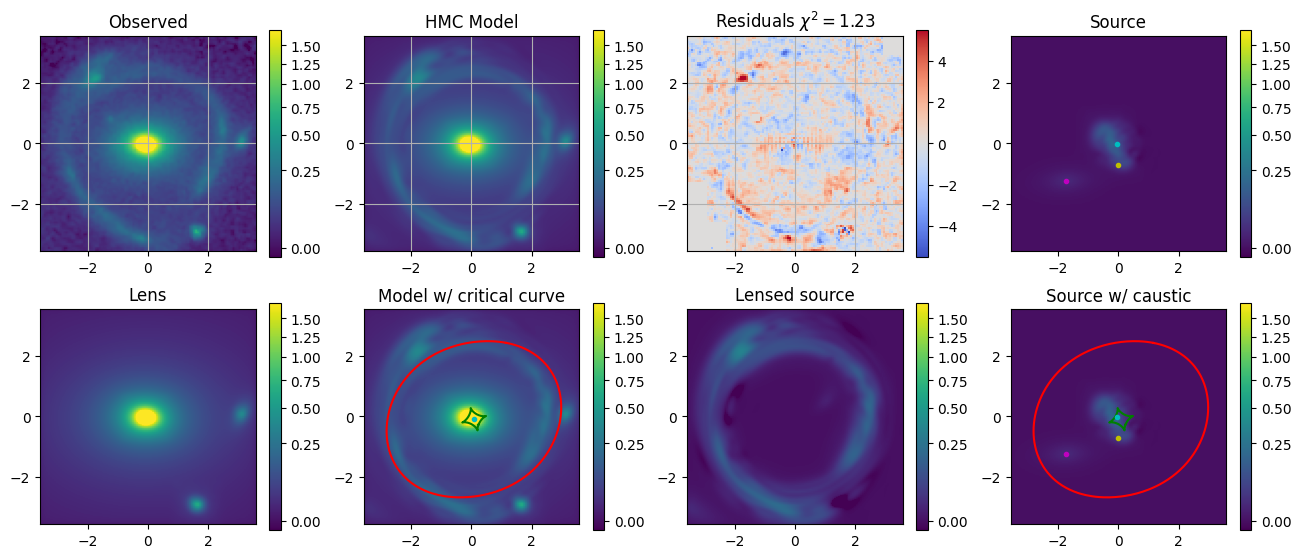

In [9]:
plt.figure(figsize=(16, 6.5))
colors = ["c.","m.","y.","w.","r.","k."]
norm = simple_norm(observed_img, 'sqrt', percent=99.)

resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

plt.subplot(241)
plt.imshow(observed_img, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Observed")
plt.colorbar()
plt.grid(which='major')

ax = plt.subplot(242)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title(MAPorHMC+" Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(243)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(244)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(245)
plt.imshow(lenssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lens")
plt.colorbar()

ax = plt.subplot(246)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
for ii in range(0,len(mass)):
    try:
        plt.plot(mass[ii]["center_x"],mass[ii]["center_y"],colors[ii])
    except:
        pass
plt.title("Model w/ critical curve")
plt.colorbar()

plt.subplot(247)
plt.imshow(masssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

ax = plt.subplot(248)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source w/ caustic")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"output.png",)#transparent=True)
print(HMCchi)

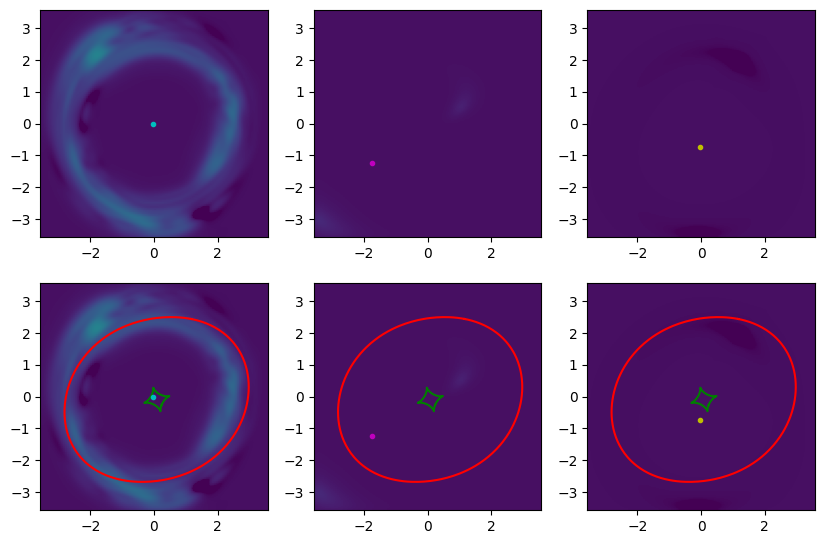

In [10]:
plt.figure(figsize=(10,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1+len(source_light))
    lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')

plt.savefig(path+"/"+MAPorHMC+"deconstructed.png",)#transparent=True)

-0.029607475
-0.0022532623


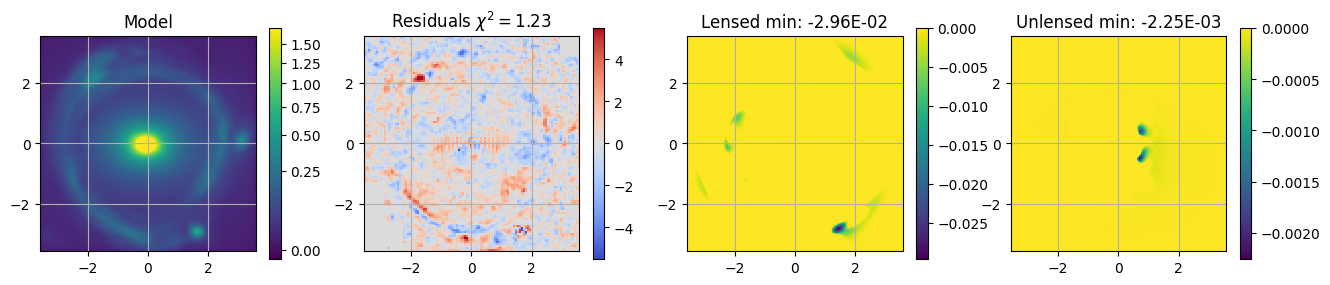

In [11]:
plt.figure(figsize=(16,3))

ax = plt.subplot(141)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(142)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(143)
plt.imshow(masssimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Lensed min: {np.min(masssimulated):.2E}")
print(np.min(masssimulated))

plt.subplot(144)
plt.imshow(sourcesimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Unlensed min: {np.min(sourcesimulated):.2E}")
print(np.min(sourcesimulated))

plt.savefig(path+"/"+MAPorHMC+"negativedetection.png")

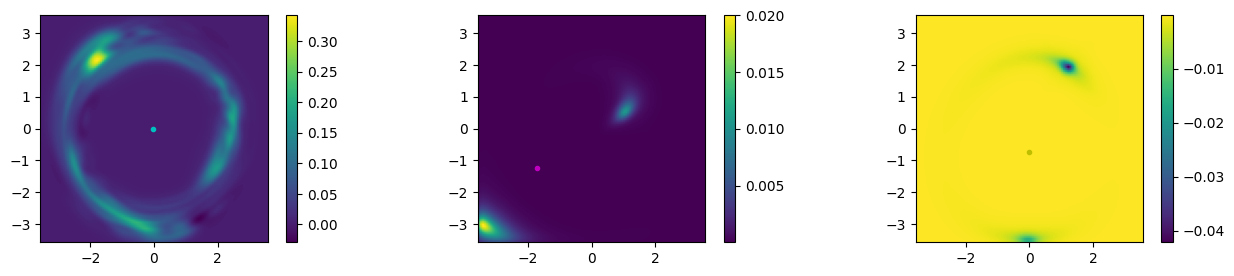

In [12]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], extent=extent, origin='lower')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.colorbar()

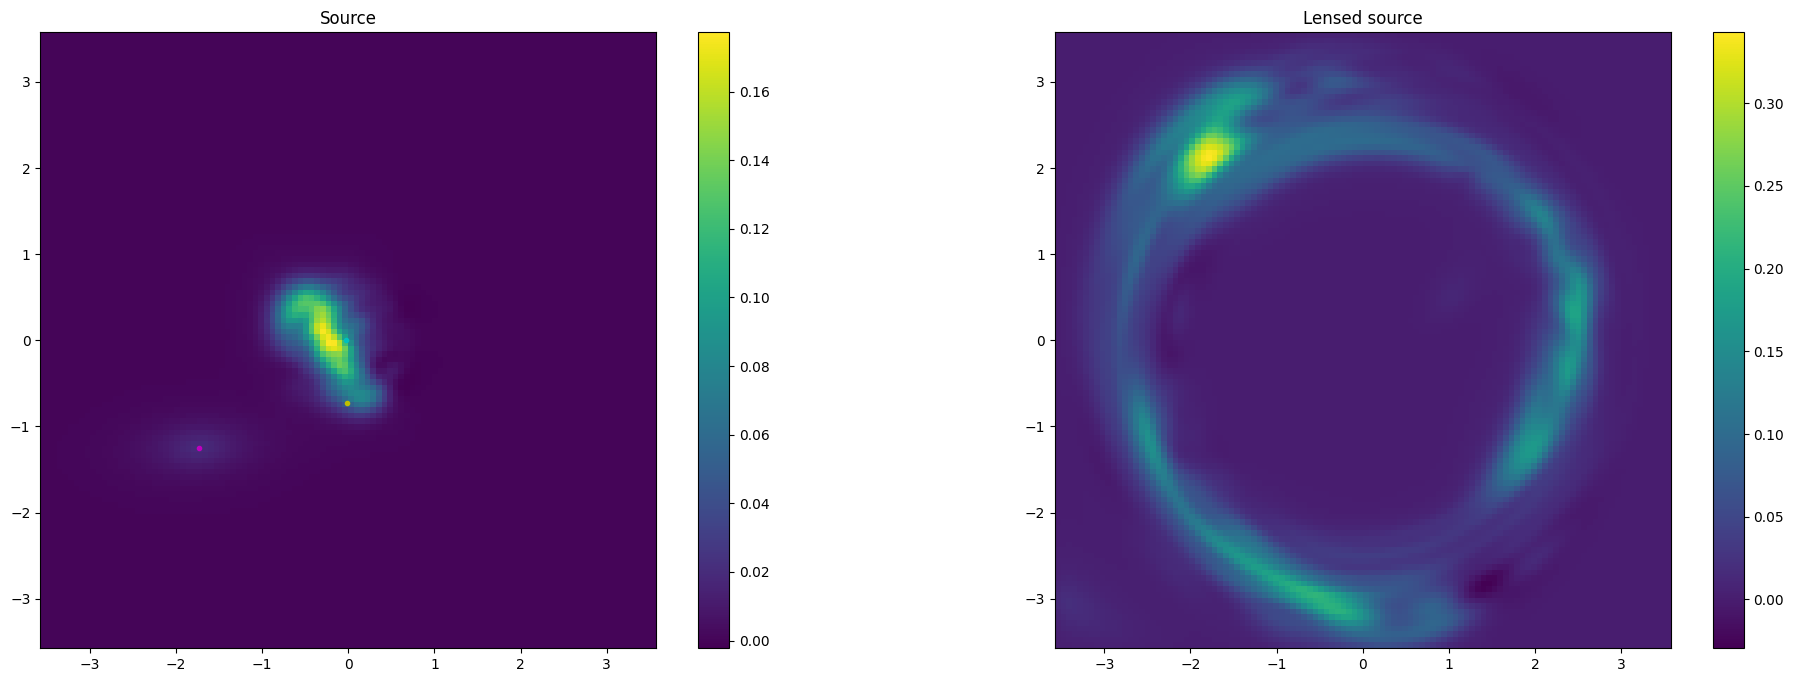

In [13]:
plt.figure(figsize=(24,8))
plt.subplot(121)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(122)
plt.imshow(masssimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"source.png",)#transparent=True)

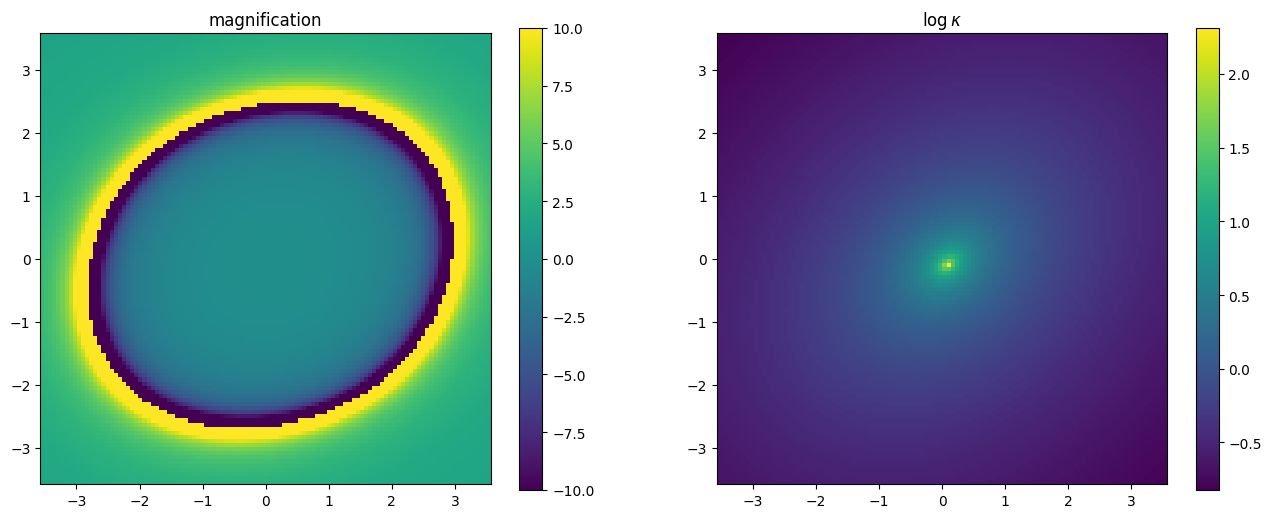

In [14]:
x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltaPix)

mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_lens)
mag2d = util.array2image(mag_grid)

kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_lens)
kappa2d = util.array2image(kappa_grid)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(mag2d, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")

plt.subplot(122)
plt.imshow(np.log10(kappa2d), origin='lower',extent=extent)
plt.colorbar()
plt.title("$\log\kappa$")
plt.savefig(path+"/"+MAPorHMC+"magkapa.png",)#transparent=True)

In [15]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lensModelNoShear = LensModel(lens_model_list=[priorObjects[0][0]])
mag_gridNoShear = lensModelNoShear.magnification(x_grid, y_grid, [kwargs_lens[0]])
mag2dNoShear = util.array2image(mag_gridNoShear)

area=np.count_nonzero(np.multiply(mag2dNoShear<1,kappa2d))*deltaPix**2
print('Area', area, 'arcsec**2')

z_lens, z_source= 1.092, 2.35
lenscosmo = LensCosmo(z_lens, z_source)
sigma_crit = lenscosmo.sigma_crit
dd = lenscosmo.dd
print(f"Critical surface density (sigma_crit): {sigma_crit} M_sun/Mpc^2")
realArea=dd**2*area*(np.pi/180/3600)**2
mass=realArea*sigma_crit
print('dd', dd)
print('Area', realArea)
print('Mass:{:.4e}'.format(mass))

Area 23.596625000000003 arcsec**2
Critical surface density (sigma_crit): 2566981440993538.5 M_sun/Mpc^2
dd 1729.5587317230543
Area 0.0016590911733652704
Mass:4.2589e+12


In [16]:
lenscosmo.dd, lenscosmo.ds, lenscosmo.dds

(1729.5587317230543, 1726.588494701713, 646.5177882048082)

/tmp/ipykernel_1170997/1240959141.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.multiply(mag2dNoShear<1,kappa2d)), origin='lower',extent=extent)


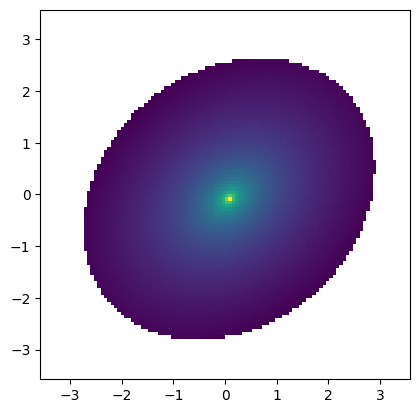

In [17]:
plt.imshow(np.log10(np.multiply(mag2dNoShear<1,kappa2d)), origin='lower',extent=extent)

In [18]:
print(np.sum(np.multiply(mag2dNoShear<1,kappa2d))/np.count_nonzero(np.multiply(mag2d<1,kappa2d)))

1.0015471706008443


In [19]:
print(np.sum(np.multiply(mag2dNoShear<1,kappa2d))))

SyntaxError: unmatched ')' (2648152124.py, line 1)

In [ ]:
plt.imshow(mag2dNoShear, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")
